Exploring the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import functions.functions as aux_fun
importlib.reload(aux_fun)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay,confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, QuantileTransformer, Normalizer, FunctionTransformer, KBinsDiscretizer
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.linear_model import LinearRegression, PoissonRegressor, Ridge
from sklearn.svm import LinearSVR



pd.options.mode.chained_assignment = None 

Reading data

In [2]:
# Read data

# Portifolio and profile datasets
portfolio = pd.read_csv('portfolio.csv')
profile = pd.read_csv('profile_clustered.csv')

# User and offer data, already treated in Data Preparation 
user_offer_df = pd.read_csv('user_offer2.csv').astype({'offer_id_rec':np.int8})

Quick look at the data

In [3]:
portfolio.head(2)

,reward,channels,difficulty,duration,offer_type,id,offer_id
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1


In [4]:
profile.head(2)

,gender,age,id,became_member_on,income,user_id,rela_member_years,user_cluster
0,NI,55.0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,64000.0,0,1.45,0
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,1.03,2


In [5]:
user_offer_df.head(2)

,offer_id_rec,user_id,valid_view_rate,completed_after_view_rate,tra_offer_infl,offer_type,gender,age,income,rela_member_years,user_cluster,age_quartile,income_quartile,member_years_quartile
0,7,3,1.0,0.0,49.39,informational,F,75.0,100000.0,1.21,2,"(64.0, 101.0]","(76000.0, 120000.0]","(0.98, 2.17]"
1,3,3,1.0,1.0,19.89,bogo,F,75.0,100000.0,1.21,2,"(64.0, 101.0]","(76000.0, 120000.0]","(0.98, 2.17]"


#### Preparing dataset

Alguns usuários receberam a mesma oferta durante o experimento. Eles podem ter completado uma parte dessas ofertas recebidas, o que gera valores de completed_after_view_rate quebrados, como 0.6, 0.25.  

Para a modelagem, será considerado duas classes para a taxa de completada. Se o usuário chegou a completa alguma das ofertas recebidas, então receberá 1. Se não, 0. 

In [6]:
# Transações

user_offer_df.columns
transactions_df = user_offer_df[['offer_id_rec','tra_offer_infl', 'offer_type', 'gender',
       'age', 'income', 'rela_member_years', 'user_cluster']]

transactions_df

,offer_id_rec,tra_offer_infl,offer_type,gender,age,income,rela_member_years,user_cluster
0,7,49.39,informational,F,75.0,100000.0,1.21,2
1,3,19.89,bogo,F,75.0,100000.0,1.21,2
2,0,21.72,bogo,F,75.0,100000.0,1.21,2
3,8,0.00,bogo,F,75.0,100000.0,1.21,2
4,7,0.00,informational,NI,55.0,64000.0,0.98,0
...,...,...,...,...,...,...,...,...
63283,5,14.83,discount,M,21.0,45000.0,0.44,3
63284,5,14.95,discount,F,63.0,68000.0,0.96,0
63285,5,30.41,discount,F,68.0,51000.0,1.15,0
63286,5,14.25,discount,M,20.0,70000.0,1.77,3


### Modeling data

#### Complete Rate

##### Data Preparation

In [7]:
user_offer_df.loc[user_offer_df.completed_after_view_rate > 0, 'completed_after_view_rate'] = 1 

user_offer_df['completed_after_view_rate'].value_counts()
# Classes balanceadas

0.0    42247
1.0    21041
Name: completed_after_view_rate, dtype: int64

In [8]:
# Duas abordagens
# Uma para a taxa de completas
# Outra para transação
# Separar os datasets para cada assunto

# 'offer_id_rec' - use to indtify the offer id
# 'user_id' - use to indtify the user id, not use in modeling
# 'valid_view_rate' - not use, since is built-in na taxa de completos
# 'completed_after_view_rate' - main variable
# 'tra_offer_infl' - not use for the first attempt
# 'offer_type' - dummy varible
# 'gender' - dummy varible
# 'age' - continuos variable, use
# 'income' - continuos variable, use
# 'rela_member_years' - - continuos variable, use
# 'user_cluster' - dummy variable
# 'age_quartile' - not use quartile groups in modeling
# 'income_quartile' - not use quartile groups in modeling
# 'member_years_quartile' - not use quartile groups in modeling


complete_df = user_offer_df[['offer_id_rec', 'completed_after_view_rate', 
    'offer_type', 'gender', 'age', 'income', 'rela_member_years', 'user_cluster']]

# Para completar, informational não tem completar
complete_df = complete_df.loc[complete_df['offer_type']!='informational']


##### Split dataset

In [9]:
# Target features and others
y = complete_df['completed_after_view_rate'] # target
X = complete_df.drop(columns='completed_after_view_rate') # features

# Split data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

##### Train

In [10]:
# Create a pipeline

# Transformer
# For Age, Income and Time as Member use a scaler (z score)
sca = StandardScaler()
# For categorical columns, as offer id, offer type, user cluster and gender
# user one hot encoder to create dummy variables.
encoder = OneHotEncoder(sparse=False, dtype='int',handle_unknown='ignore')

# Classifier
# Use Decision Tree to fit data. Class weight is set to balanced to
# balance the size of each class in dataset.
clf = DecisionTreeClassifier(class_weight='balanced')


# Column Transformer chain, since the columns will receive different
# transformations. For numeric columns, the type is float64.
transformers = make_column_transformer( 
    (sca, make_column_selector(dtype_include=np.float64)),
    (encoder, make_column_selector(dtype_exclude=np.float64))
)

# Pipeline
model = Pipeline(
    [
        ('tranformer', transformers),
        ('classifier', clf)
    ]
)

# Fit model to train data
model.fit(X_train, y_train)

Pipeline(steps=[('tranformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024C81883A60>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024C81883D60>)])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced'))])

##### Test

Perfomance with Train

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     20795
         1.0       0.99      0.99      0.99     14650

    accuracy                           0.99     35445
   macro avg       0.99      0.99      0.99     35445
weighted avg       0.99      0.99      0.99     35445



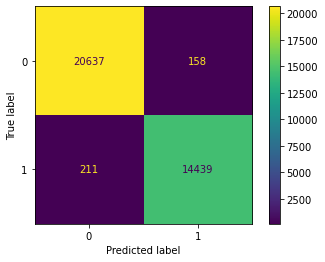

Perfomance with Test

              precision    recall  f1-score   support

         0.0       0.68      0.69      0.69      8801
         1.0       0.57      0.56      0.56      6391

    accuracy                           0.64     15192
   macro avg       0.63      0.63      0.63     15192
weighted avg       0.64      0.64      0.64     15192



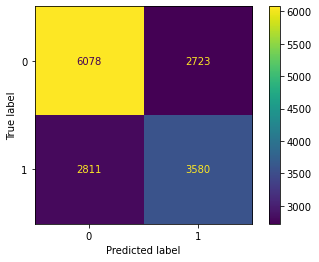

In [11]:
# Evaluation of results
aux_fun.evaluate_model(model, X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test)

Overfitting com dados de treinamento.

Baseado no recall, tentar otimizar essa métrica modificando a profundidada da árvore

GridSearch para achar os melhores parâmetros para o modelo

In [12]:
# Get params names
model.get_params()

{'memory': None,
 'steps': [('tranformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000024C81883A60>),
                                   ('onehotencoder',
                                    OneHotEncoder(dtype='int',
                                                  handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000024C81883D60>)])),
  ('classifier', DecisionTreeClassifier(class_weight='balanced'))],
 'verbose': False,
 'tranformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024C81883A60>),
                                 ('onehotencoder',
                            

In [13]:
# Usar gridsearch para procurar a melhor profundidade da árvore
params_grid = {
    'classifier__max_depth':range(5,40), 
    'classifier__criterion': ['gini', 'entropy']    
}

# GridSearch
pipeline_gs = GridSearchCV(model, params_grid, scoring='recall_micro')

# Fit
pipeline_gs.fit(X_train, y_train)

# Best result
model_gs = pipeline_gs.best_estimator_

In [14]:
model_gs

Pipeline(steps=[('tranformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024C8423FBB0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024C8423FF40>)])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=10))])

Perfomance with Train

              precision    recall  f1-score   support

         0.0       0.79      0.71      0.75     20795
         1.0       0.64      0.73      0.68     14650

    accuracy                           0.72     35445
   macro avg       0.71      0.72      0.72     35445
weighted avg       0.73      0.72      0.72     35445



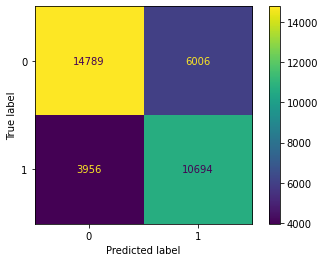

Perfomance with Test

              precision    recall  f1-score   support

         0.0       0.76      0.70      0.73      8801
         1.0       0.63      0.70      0.66      6391

    accuracy                           0.70     15192
   macro avg       0.70      0.70      0.70     15192
weighted avg       0.71      0.70      0.70     15192



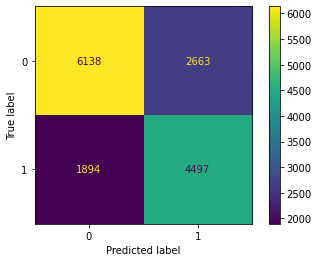

In [15]:
# Evaluate the grid serach best model
aux_fun.evaluate_model(model_gs, X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test)

Recall melhor, porém, ainda não ideal

Recall é a melhor métrica para avaliar, pois compara os valores ao que é visto na realidade.

##### Evaluation

Avaliando as imporâncias das variáveis na previsão

In [16]:
model_gs

Pipeline(steps=[('tranformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024C8423FBB0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(dtype='int',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024C8423FF40>)])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=10))])

In [17]:
# Olhando a importancia de cada variável na classificação
def create_df_feature_importances(model):
    '''
    TODO
    '''
    df_feature = pd.DataFrame()
    df_feature['Variable'] = model.named_steps['tranformer'].get_feature_names_out()
    df_feature['Variable'] = df_feature['Variable'].map(lambda n: n.split('__')[1])
    
    df_feature['Importance'] = model.named_steps['classifier'].feature_importances_
    return df_feature

create_df_feature_importances(model_gs).sort_values('Importance', ascending=False)

,Variable,Importance
2,rela_member_years,0.284084
15,gender_NI,0.168304
6,offer_id_rec_4,0.108457
1,income,0.103562
8,offer_id_rec_6,0.095354
7,offer_id_rec_5,0.093268
0,age,0.046732
9,offer_id_rec_8,0.042034
14,gender_M,0.023550
4,offer_id_rec_1,0.009811


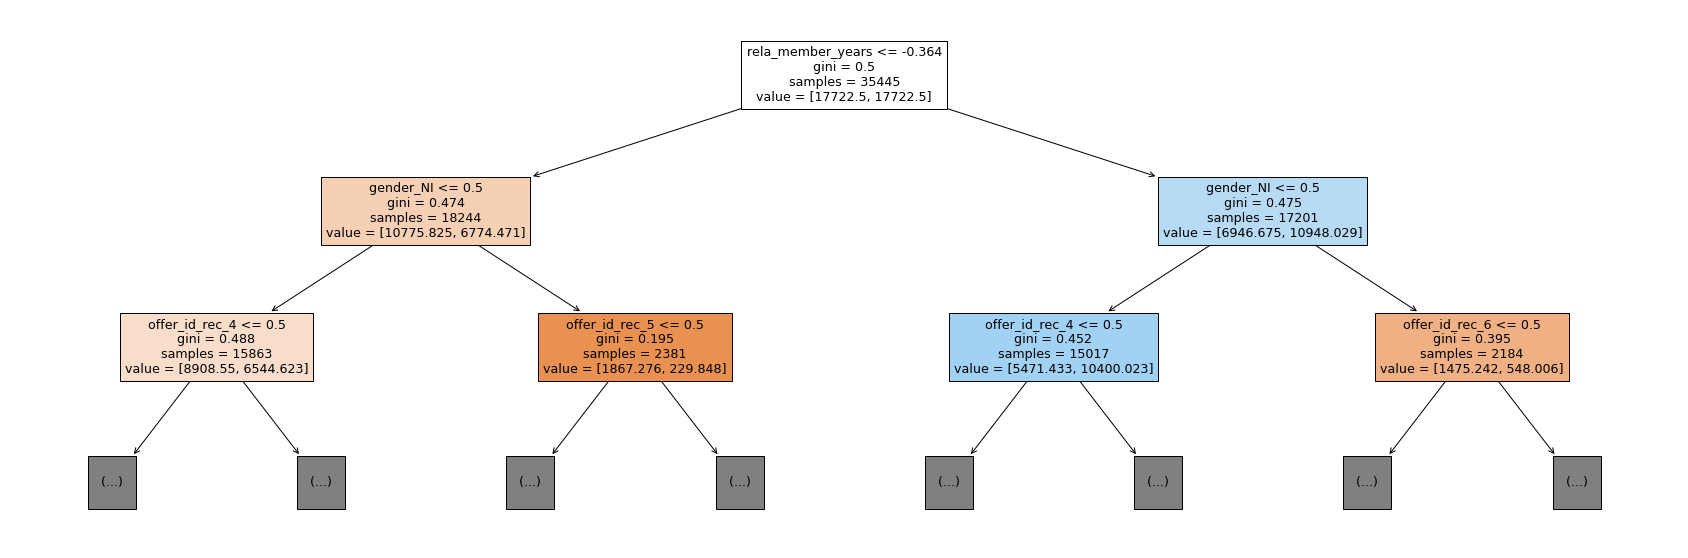

In [18]:
# Visualizando a árvore

named_variables =  model.named_steps['tranformer'].get_feature_names_out()
named_variables = [ name.split('__')[1] for name in named_variables]

clf_tree = model.named_steps['classifier']

plt.figure(figsize=(30,10))


plot_tree(clf_tree, max_depth=2, feature_names=named_variables, filled=True)
plt.show()

A falta de informações (gender == NI) impacta no modelo, sendo um ponto de divisão para os dados.

In [19]:
model_completation = model_gs

Como usar esse modelo

##### Deployment

In [20]:
X_train

,offer_id_rec,offer_type,gender,age,income,rela_member_years,user_cluster
7108,4,discount,M,21.0,32000.0,1.40,3
27911,9,discount,F,64.0,73000.0,1.89,2
39738,6,discount,F,73.0,77000.0,0.19,2
55672,5,discount,M,67.0,41000.0,0.29,0
44020,4,discount,M,25.0,30000.0,0.43,3
...,...,...,...,...,...,...,...
48524,0,bogo,M,18.0,45000.0,1.53,3
51161,5,discount,M,54.0,37000.0,0.30,3
37118,9,discount,NI,55.0,64000.0,1.37,0
7268,0,bogo,M,23.0,31000.0,0.52,3


In [46]:
# Usar o modelo para enviar ofertas para usuários

# O modelo criado pode ser utilizado para selecionar quais ofertas seriam completadas
# a partir do perfil do usuário.
importlib.reload(aux_fun)

def best_user_offer_to_send(user, model, X):
    # Filter user in profile
    user_df = profile.loc[profile['user_id']==user]
    # Select columns
    user_df = user_df[['gender', 'age', 'income', 'rela_member_years', 'user_cluster']]
    
    # Criar uma simulação de entregar todas as ofertas para o usuário
    offers_df = portfolio[['offer_id', 'offer_type']]
    offers_df.columns = ['offer_id_rec', 'offer_type']
    offers_df = aux_fun.expand_dataframe(user_df, offers_df)

    # Garantee order of columns
    offers_df = offers_df[X.columns]
    # Take away intormational offers
    # offers_df = offers_df.loc[offers_df['offer_type']!='informational']
    
    # Predict
    offers_df['complete_pred'] = model.predict(offers_df)
    
    # Filter
    best_offers = offers_df.loc[offers_df['complete_pred'] == 1]

    # Create list
    recs = []
    for idx, row in best_offers.iterrows():
        recs.append(str(row['offer_id_rec']) +\
            ' - ' + str(row['offer_type']))
    
    print(f'Offers for {user}: {recs}')
    
    return recs#best_offers

for user in range(0,5):
    best_user_offer_to_send(user, model_gs, X)


Offers for 0: ['0 - bogo', '1 - bogo', '3 - bogo', '5 - discount', '6 - discount', '7 - informational', '8 - bogo', '9 - discount']
Offers for 1: ['0 - bogo', '1 - bogo', '5 - discount', '6 - discount', '8 - bogo']
Offers for 2: []
Offers for 3: ['0 - bogo', '1 - bogo', '2 - informational', '5 - discount', '6 - discount', '8 - bogo']
Offers for 4: ['0 - bogo', '1 - bogo', '5 - discount', '6 - discount', '8 - bogo']


#### Transações

O modelo anterior pode ser combinado com um modelo de regressão para o total de transações a partir da oferta enviada para cada usuário

##### Data preparation

In [23]:
# Transações

user_offer_df.columns

transactions_df = user_offer_df[['offer_id_rec','tra_offer_infl', 'offer_type', 'gender',
       'age', 'income', 'rela_member_years', 'user_cluster']]

transactions_df

,offer_id_rec,tra_offer_infl,offer_type,gender,age,income,rela_member_years,user_cluster
0,7,49.39,informational,F,75.0,100000.0,1.21,2
1,3,19.89,bogo,F,75.0,100000.0,1.21,2
2,0,21.72,bogo,F,75.0,100000.0,1.21,2
3,8,0.00,bogo,F,75.0,100000.0,1.21,2
4,7,0.00,informational,NI,55.0,64000.0,0.98,0
...,...,...,...,...,...,...,...,...
63283,5,14.83,discount,M,21.0,45000.0,0.44,3
63284,5,14.95,discount,F,63.0,68000.0,0.96,0
63285,5,30.41,discount,F,68.0,51000.0,1.15,0
63286,5,14.25,discount,M,20.0,70000.0,1.77,3


In [24]:
# Target features and others
y = transactions_df['tra_offer_infl'] # target
X = transactions_df.drop(columns='tra_offer_infl') # features

# Split data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


##### Train

In [25]:
# Create a pipeline

# Transformer
# For Age, Income and Time as Member use a scaler (z score)
sca = StandardScaler()
# For categorical columns, as offer id, offer type, user cluster and gender
# user one hot encoder to create dummy variables.
encoder = OneHotEncoder(sparse=False, dtype='int')

# Classifier
# Use LinearRegression to fit data. Class weight is set to balanced to
# balance the size of each class in dataset.
reg = LinearRegression() # standart reg

# Column Transformer chain, since the columns will receive different
# transformations. For numeric columns, the type is float64.
transformers = make_column_transformer( 
    (sca, make_column_selector(dtype_include=np.float64)),
    (encoder, make_column_selector(dtype_exclude=np.float64))
)

# Pipeline
model_reg = Pipeline(
    [
        ('tranformer', transformers),
        ('regressor', reg)
    ]
)

# Fit model to train data
model_reg.fit(X_train, y_train)

Pipeline(steps=[('tranformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024C8432CE80>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(dtype='int',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024C84326220>)])),
                ('regressor', LinearRegression())])

In [26]:
model_reg.score(X_test, y_test)

0.03351218485162066

##### Test

Perfomance with Train

R2: 0.035396425901886186
Perfomance with Test

R2: 0.03351218485162066
Residuals plot


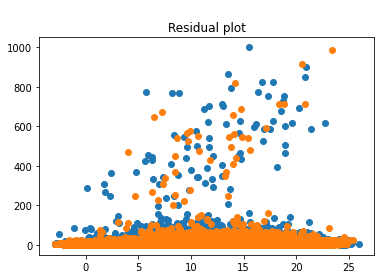

In [27]:
# Evaluation of results
importlib.reload(aux_fun)
aux_fun.evaluate_model_reg(model_reg, X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test)

A regressão tem desempenho por alguns valores altos.

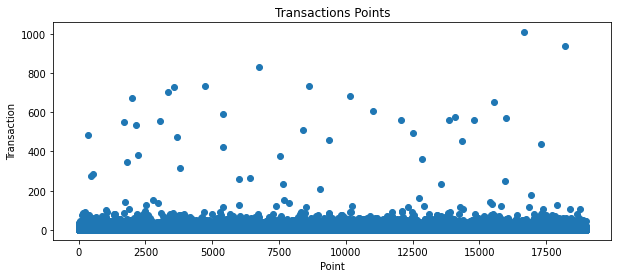

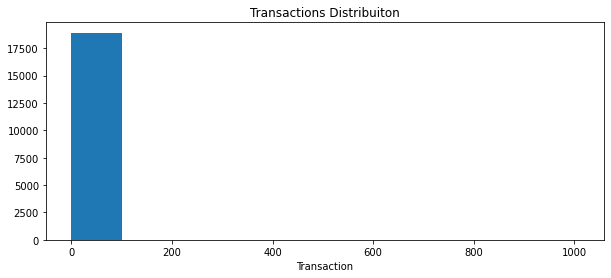

In [28]:
# Olhando para os valores de treino

plt.figure(figsize=(10,4))
x = np.arange(len(y_test))
plt.scatter(x, y_test)
plt.title('Transactions Points'); plt.xlabel('Point'); plt.ylabel('Transaction')
plt.show()

plt.figure(figsize=(10,4))
plt.hist(y_test)
plt.title('Transactions Distribuiton'); plt.xlabel('Transaction')
plt.show()

O problema do primeiro fit é que a maior parte dos dados é 0. Há poucos valores acima, o que causa grandes erros no fit do modelo.

Grid Search para outro modelo de regressão

In [29]:
model_reg.get_params()

{'memory': None,
 'steps': [('tranformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000024C8432CE80>),
                                   ('onehotencoder',
                                    OneHotEncoder(dtype='int', sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000024C84326220>)])),
  ('regressor', LinearRegression())],
 'verbose': False,
 'tranformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024C8432CE80>),
                                 ('onehotencoder',
                                  OneHotEncoder(dtype='int', sparse=False),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000

In [30]:
# Create a pipeline

# Classifier
# Test other regressor with data. To see other results
reg1 = LinearRegression()
reg2 = PoissonRegressor(fit_intercept=False, max_iter=5100)

# Usar gridsearch para procurar a melhor profundidade da árvore
params_grid = {
    'regressor': [reg1, reg2]
}

# GridSearch
pipeline_reg_gs = GridSearchCV(model_reg, params_grid, scoring='r2')

# Fit
pipeline_reg_gs.fit(X_train, y_train)

# Best result
model_reg_gs = pipeline_gs.best_estimator_

pipeline_reg_gs.cv_results_['mean_test_score']

array([0.03425408, 0.02559892])

In [31]:
# 

Os resultados não são bom para os regressores testados. Logo, o problema está, realmente, no intervalo de y para poder prever.

In [32]:
# Transform in target variable

# Creating a new pipeline

# The transforms will be keeped in place

# Classifier

# Use a transform target regrossor

# Use LinearRegression to fit data. Class weight is set to balanced to
# balance the size of each class in dataset.
reg = LinearRegression() # standart reg
trans = FunctionTransformer() # the transformer

trans_regr = TransformedTargetRegressor(regressor=reg, transformer=trans)

# Column Transformer chain, since the columns will receive different
# transformations. For numeric columns, the type is float64.

# Pipeline
model_reg2 = Pipeline(
    [
        ('tranformer', transformers),
        ('regressor', trans_regr)
    ]
)

# Fit model to train data
model_reg2.fit(X_train, y_train)

model_reg2.score(X_train, y_train)

0.035396425901886186

A regressão linear paraece não funcionar bem para o caso da transação

A estratégia a ser seguida será transformar a transação em classe. Haverá classe imbalanced, porém métodos de classificação como ávore de decisão conseguem lidar com esse tipo de problema ao fazer oversample, por exemplo

<AxesSubplot:>

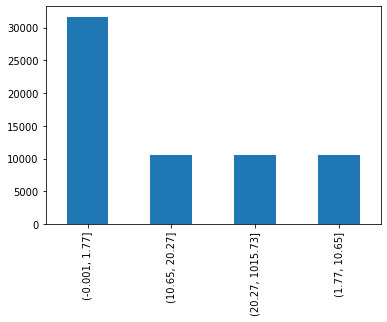

In [33]:
# A melhor divisão para y

pd.qcut(y, q=6, duplicates='drop').value_counts().plot.bar()

4 classes, com desbalanceio.

In [34]:
# Redefing the data

# Target features and others
y = transactions_df[['tra_offer_infl']] # target
X = transactions_df.drop(columns='tra_offer_infl') # features

# Classing the transactions
y.loc[y['tra_offer_infl'] > 0, 'tra_offer_infl'] = 1  

# Split data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Train

In [35]:
# Create a pipeline

# Transformer
# For Age, Income and Time as Member use a scaler (z score)
sca = StandardScaler()
# For categorical columns, as offer id, offer type, user cluster and gender
# user one hot encoder to create dummy variables.
encoder = OneHotEncoder(sparse=False, dtype='int')

# Classifier
# Use Decision Tree to fit data. Class weight is set to balanced to
# balance the size of each class in dataset.
clf = DecisionTreeClassifier(class_weight='balanced')


# Column Transformer chain, since the columns will receive different
# transformations. For numeric columns, the type is float64.
transformers = make_column_transformer( 
    (sca, make_column_selector(dtype_include=np.float64)),
    (encoder, make_column_selector(dtype_exclude=np.float64))
)

# Pipeline
model = Pipeline(
    [
        ('tranformer', transformers),
        ('classifier', clf)
    ]
)

# Fit model to train data
model.fit(X_train, y_train)

Pipeline(steps=[('tranformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024C84307DF0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(dtype='int',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024C84307C10>)])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced'))])

Perfomance with Train

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     20708
         1.0       0.99      0.97      0.98     23593

    accuracy                           0.98     44301
   macro avg       0.98      0.98      0.98     44301
weighted avg       0.98      0.98      0.98     44301



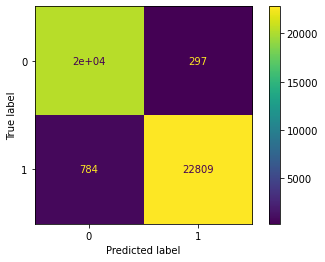

Perfomance with Test

              precision    recall  f1-score   support

         0.0       0.58      0.59      0.59      8877
         1.0       0.63      0.62      0.63     10110

    accuracy                           0.61     18987
   macro avg       0.61      0.61      0.61     18987
weighted avg       0.61      0.61      0.61     18987



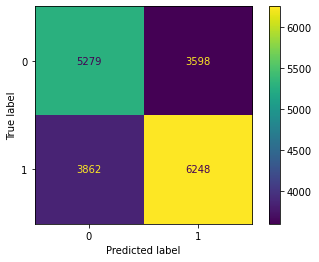

In [36]:
# Evaluation of results
aux_fun.evaluate_model(model, X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test)

In [37]:
# Usar gridsearch para procurar a melhor profundidade da árvore
params_grid = {
    'classifier__max_depth':range(5,40), 
    'classifier__criterion': ['gini', 'entropy'] 
}

# GridSearch
pipeline_gs = GridSearchCV(model, params_grid, scoring='recall_micro')

# Fit
pipeline_gs.fit(X_train, y_train)

# Best result
model_gs = pipeline_gs.best_estimator_

Perfomance with Train

              precision    recall  f1-score   support

         0.0       0.69      0.67      0.68     20708
         1.0       0.72      0.74      0.73     23593

    accuracy                           0.71     44301
   macro avg       0.71      0.70      0.71     44301
weighted avg       0.71      0.71      0.71     44301



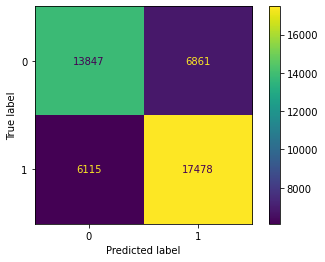

Perfomance with Test

              precision    recall  f1-score   support

         0.0       0.67      0.65      0.66      8877
         1.0       0.70      0.72      0.71     10110

    accuracy                           0.69     18987
   macro avg       0.69      0.69      0.69     18987
weighted avg       0.69      0.69      0.69     18987



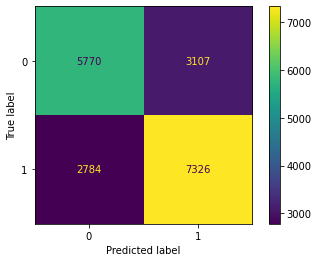

In [38]:
# Evaluate the grid serach best model
aux_fun.evaluate_model(model_gs, X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test)

Resulto melhor para a classificação

In [39]:
# Olhando a importancia de cada variável na classificação
def create_df_feature_importances(model):
    '''
    TODO
    '''
    df_feature = pd.DataFrame()
    df_feature['Variable'] = model.named_steps['tranformer'].get_feature_names_out()
    df_feature['Variable'] = df_feature['Variable'].map(lambda n: n.split('__')[1])
    
    df_feature['Importance'] = model.named_steps['classifier'].feature_importances_
    return df_feature

create_df_feature_importances(model_gs).sort_values('Importance', ascending=False)

,Variable,Importance
2,rela_member_years,0.182391
7,offer_id_rec_4,0.156237
6,offer_id_rec_3,0.131267
1,income,0.130750
12,offer_id_rec_9,0.128485
5,offer_id_rec_2,0.122468
15,offer_type_informational,0.049421
0,age,0.047148
10,offer_id_rec_7,0.017583
3,offer_id_rec_0,0.007002


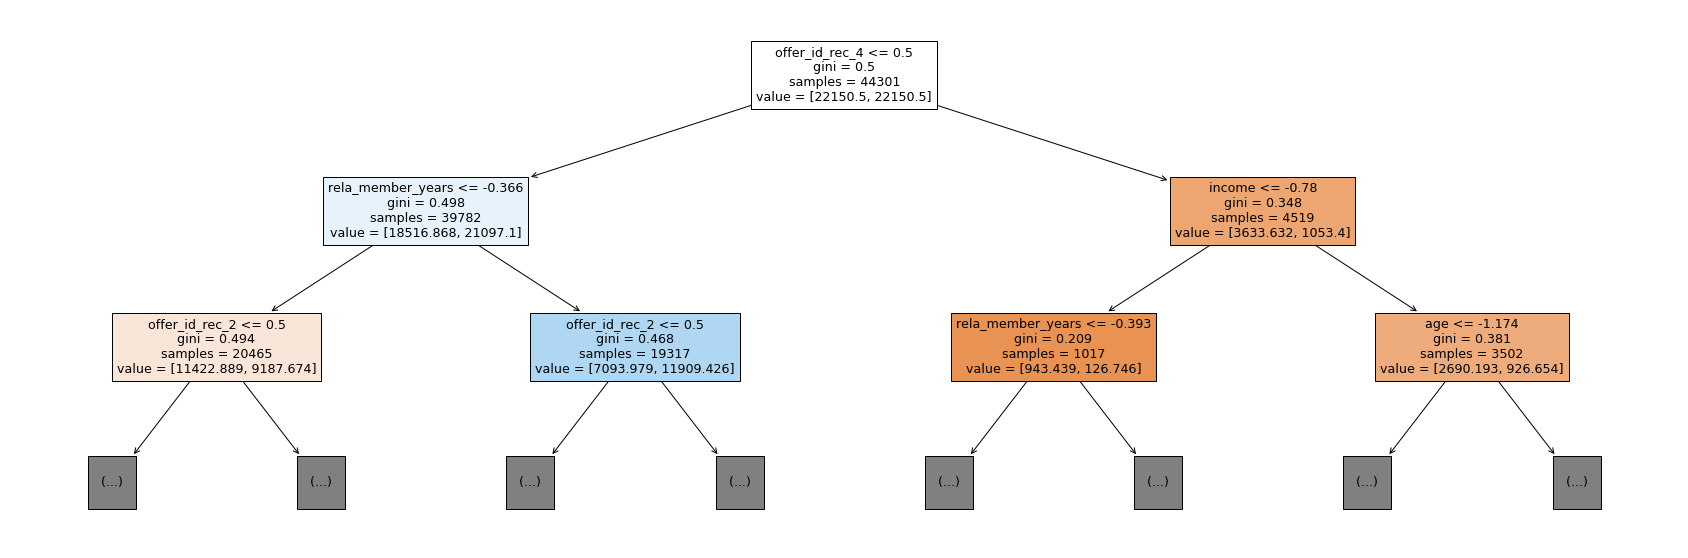

In [40]:
# Visualizando a árvore

named_variables =  model.named_steps['tranformer'].get_feature_names_out()
named_variables = [ name.split('__')[1] for name in named_variables]

clf_tree = model.named_steps['classifier']

plt.figure(figsize=(30,10))


plot_tree(clf_tree, max_depth=2, feature_names=named_variables, filled=True)
plt.show()

In [41]:
model_transaction = model_gs

#### Combinando os dois modelos

In [42]:
model_transaction
# model_completation

Pipeline(steps=[('tranformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024C81644B20>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(dtype='int',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024C81644640>)])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=9))])

In [43]:
# Improving the previos function

def best_user_offer_to_send2(user, model_completation, model_transaction, X):
    # Filter user in profile
    user_df = profile.loc[profile['user_id']==user]
    # Select columns
    user_df = user_df[['gender', 'age', 'income', 'rela_member_years', 'user_cluster']]
    
    # Criar uma simulação de entregar todas as ofertas para o usuário
    offers_df = portfolio[['offer_id', 'offer_type']]
    offers_df.columns = ['offer_id_rec', 'offer_type']
    offers_df = aux_fun.expand_dataframe(user_df, offers_df)

    # Garantee order of columns
    offers_df = offers_df[X.columns]
    # Take away intormational offers
    # offers_df = offers_df.loc[offers_df['offer_type']!='informational']
    
    # Predict Completation
    offers_df['complete_pred'] = model_completation.predict(offers_df)
    # Predict Transactions
    offers_df['transaction_pred'] = model_transaction.predict(offers_df)
    
    # Filter
    offers_df['score'] = offers_df['complete_pred']*offers_df['transaction_pred']
    best_offers = offers_df.loc[offers_df['score'] == 1]

    # Create list
    recs = []
    for idx, row in best_offers.iterrows():
        recs.append(str(row['offer_id_rec']) +\
            ' - ' + str(row['offer_type']))
    
    print(f'Offers for {user}: {recs}')
    
    return recs#best_offers

for user in range(0,100):
    best_user_offer_to_send2(user, model_completation, model_transaction, X)

# best_user_offer_to_send2(1510, model_completation, model_transaction, X)

Offers for 0: ['5 - discount', '6 - discount', '8 - bogo']
Offers for 1: ['1 - bogo', '5 - discount', '6 - discount', '8 - bogo']
Offers for 2: []
Offers for 3: ['0 - bogo', '1 - bogo', '2 - informational', '5 - discount', '6 - discount', '8 - bogo']
Offers for 4: []
Offers for 5: []
Offers for 6: []
Offers for 7: []
Offers for 8: ['6 - discount']
Offers for 9: ['6 - discount']
Offers for 10: []
Offers for 11: ['3 - bogo', '5 - discount', '6 - discount']
Offers for 12: ['5 - discount', '6 - discount']
Offers for 13: ['0 - bogo', '1 - bogo', '5 - discount', '6 - discount', '8 - bogo']
Offers for 14: ['5 - discount', '6 - discount', '8 - bogo']
Offers for 15: ['0 - bogo', '1 - bogo', '3 - bogo', '5 - discount', '6 - discount', '7 - informational', '8 - bogo', '9 - discount']
Offers for 16: ['0 - bogo', '1 - bogo', '3 - bogo', '5 - discount', '6 - discount', '7 - informational', '8 - bogo', '9 - discount']
Offers for 17: []
Offers for 18: ['5 - discount', '6 - discount']
Offers for 19: ['

COMENTAR AQUI